In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import collections
import os
import sys
import random

sys.path.append('../code/')

import routenet_with_link_cap as rout


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Second is to load a RouteNet model already trained, for this we need to apply the same 
hyperparamters values used in the training. The following code specifies such 
hyperparameters. 

In [3]:
# hparams = rout.hparams.parse("l2=0.1,dropout_rate=0.5,link_state_dim=32,path_state_dim=32,readout_units=256,learning_rate=0.001,T=8")

hparams = rout.hparams.parse("l2=0.01,dropout_rate=0.5,link_state_dim=64,path_state_dim=64,readout_units=256,learning_rate=0.0001,T=4")

The following code block loads some functions used to process the datasets:

In [4]:
def parse(serialized, target='delay'):
    '''
    Target is the name of predicted variable
    '''
    with tf.device("/cpu:0"):
        with tf.name_scope('parse'):
            features = tf.parse_single_example(
                serialized,
                features={
                    'traffic':tf.VarLenFeature(tf.float32),
                    target:tf.VarLenFeature(tf.float32),
                    'link_capacity': tf.VarLenFeature(tf.float32),
                    'links':tf.VarLenFeature(tf.int64),
                    'paths':tf.VarLenFeature(tf.int64),
                    'sequences':tf.VarLenFeature(tf.int64),
                    'n_links':tf.FixedLenFeature([],tf.int64),
                    'n_paths':tf.FixedLenFeature([],tf.int64),
                    'n_total':tf.FixedLenFeature([],tf.int64)
                })
            for k in ['traffic',target,'link_capacity','links','paths','sequences']:
                features[k] = tf.sparse_tensor_to_dense(features[k])
                if k == 'traffic':
                    features[k] = (features[k] - 0.17) / 0.13
                if k == 'link_capacity':
                    features[k] = (features[k] - 25.0) / 40.0

    return {k:v for k,v in features.items() if k is not target },features[target]

def read_dataset():
    ds = tf.data.TFRecordDataset(sample_file)

    # We parse the serialized input from the file
    ds = ds.map(lambda buf: parse(buf))

    ds = ds.batch(1)

    it = ds.make_initializable_iterator()

    return it

# Delay prediction with RouteNet


In [5]:
# random.seed(13)
# Path to downloaded datasets
path = '/home/hao/demo-routenet/code/nsfnetbw/tfrecords/train/'
filename = random.choice(os.listdir(path))
sample_file = path + filename
print(sample_file)

/home/hao/demo-routenet/code/nsfnetbw/tfrecords/train/results_nsfnetbw_15_Routing_W_6_k_9.tfrecords


Then,   we   load   the   model   provided   in   our   GitHub   repository   to   produce   delay predictions. For the predictions, we use the first sample from the file selected above:

In [7]:
graphPredict = tf.Graph()
with graphPredict.as_default():
    model = rout.ComnetModel(hparams)
    model.build()

    it = read_dataset()
    features, label = it.get_next()

    with tf.name_scope('predict'):
        predictions = tf.map_fn(lambda x: model(x, training=True), features, dtype=tf.float32)

    preds = tf.squeeze(predictions)
    predictions = 0.54*preds + 0.37

inputs =  {'link_capacity': <tf.Tensor 'predict/map/while/TensorArrayReadV3:0' shape=(?,) dtype=float32>, 'links': <tf.Tensor 'predict/map/while/TensorArrayReadV3_1:0' shape=(?,) dtype=int64>, 'paths': <tf.Tensor 'predict/map/while/TensorArrayReadV3_5:0' shape=(?,) dtype=int64>, 'sequences': <tf.Tensor 'predict/map/while/TensorArrayReadV3_6:0' shape=(?,) dtype=int64>, 'traffic': <tf.Tensor 'predict/map/while/TensorArrayReadV3_7:0' shape=(?,) dtype=float32>, 'n_links': <tf.Tensor 'predict/map/while/TensorArrayReadV3_2:0' shape=() dtype=int64>, 'n_paths': <tf.Tensor 'predict/map/while/TensorArrayReadV3_3:0' shape=() dtype=int64>, 'n_total': <tf.Tensor 'predict/map/while/TensorArrayReadV3_4:0' shape=() dtype=int64>}
link_shape =  Tensor("predict/map/while/comnet_model/Shape:0", shape=(2,), dtype=int32)


In [9]:
with tf.compat.v1.Session(graph=graphPredict) as sess:
    sess.run(tf.compat.v1.local_variables_initializer())
    sess.run(tf.compat.v1.global_variables_initializer())
    saver = tf.compat.v1.train.Saver()
    # path to the checkpoint we want to restore
    saver.restore(sess, '../code/CheckPoints/model.ckpt-17821')

    hats = []
    for i in range(50):
        sess.run(it.initializer)
        pred_Delay, label_Delay = sess.run([predictions, label])
        hats.append(pred_Delay)

    final_prediction = np.median(hats, axis=0)

INFO:tensorflow:Restoring parameters from ../code/CheckPoints/model.ckpt-17821


# Plot Result

In [10]:
num_paths = 40 # Set how many paths you want to visualize
ids = random.sample(range(0, len(final_prediction)), num_paths)
ids.sort()

sample_prediction = []
sample_label = []

for i in ids:
    sample_prediction.append(final_prediction[i])
    sample_label.append(label_Delay[0][i])

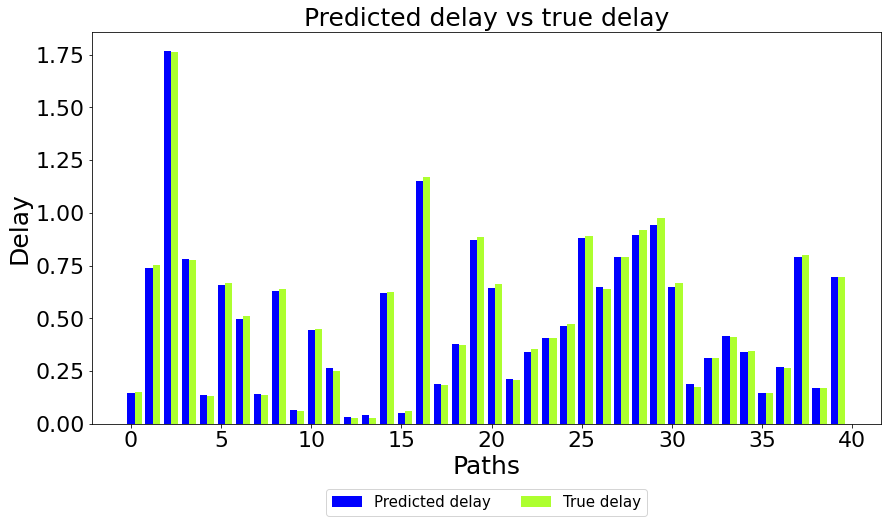

In [21]:
# create plot
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, sample_prediction, bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, sample_label, bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.2),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# Mean Square Error

In [12]:
# Mean Square Error
mse = np.square(np.asarray(sample_label)-np.asarray(sample_prediction)).mean()
print(mse)

0.000119866


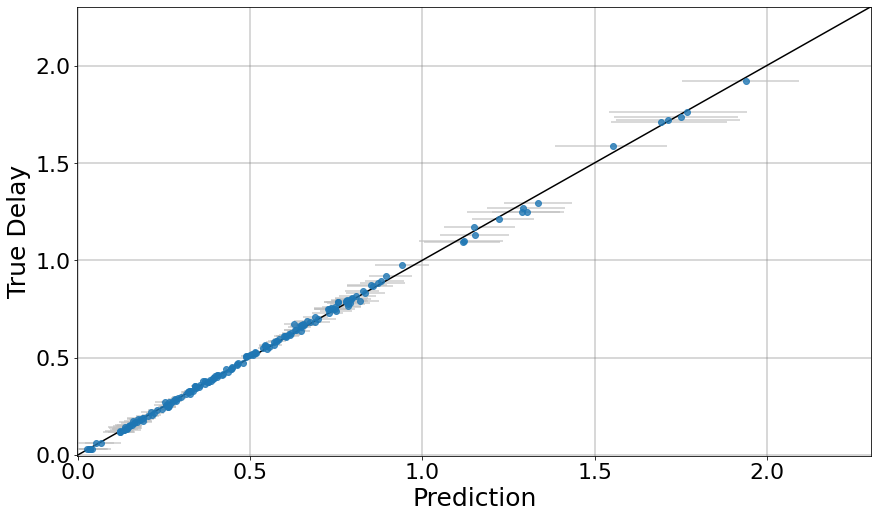

In [13]:
ax = plt.subplot()

xerr = [final_prediction - np.percentile(hats, q=5, axis=0),
        np.percentile(hats, q=95, axis=0) - final_prediction]

ax.errorbar(x=final_prediction, y=label_Delay[0], fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(label_Delay[0])
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

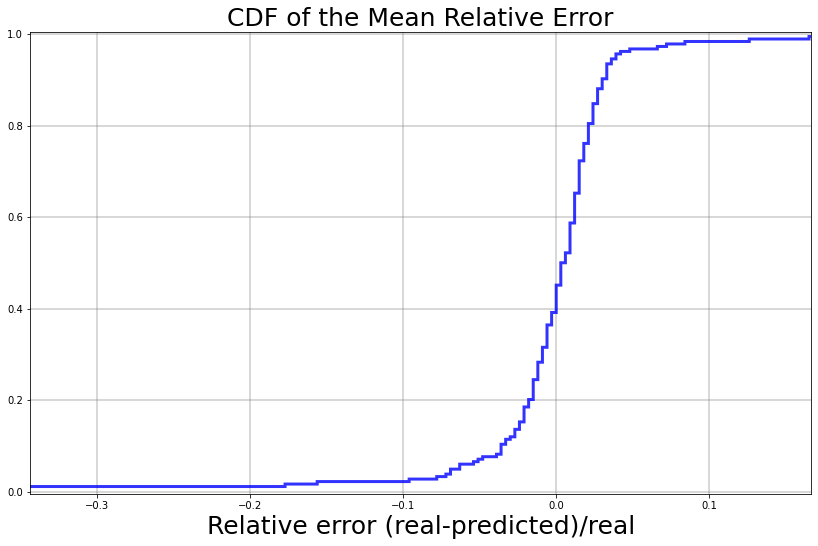

In [14]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (label_Delay-final_prediction)/label_Delay
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, histtype='step', bins=10000, alpha=0.8, color='blue', density=True, linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# References

Rusek, K., Suárez-Varela, J., Mestres, A., Barlet-Ros, P., & Cabellos-Aparicio, A. (2019, April). Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN. In Proceedings of the 2019 ACM Symposium on SDN Research (pp. 140-151). ACM.
